# analyze.fit.result.ipynb
- 22.10.10
- Gregory S.H. Paek

In [95]:
import glob, os
from astropy.io import ascii
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack
import matplotlib as mpl
from astropy import units as u
import speclite.filters
import time
import sncosmo

In [96]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 20
plt.rcParams['savefig.dpi'] = 200
plt.rc('font', family='serif')

- Function

In [97]:
def make_confusion_matrix(arr0, arr1, alarr0, alarr1):
	"""
	arr0 (x-axis)
	arr1 (y-axis)

	alarr0
	alarr1
	"""
	# blank lists
	conflist = []
	conflist_all = []

	# iteration
	# y-axis (top --> down)
	for val1 in np.flipud(np.unique(arr1)):
		xlist = []
		xlist_all = []
		# x-axis (left --> right)
		for val0 in np.unique(arr0):
			# the number of consistent models
			nparam = len(arr0[(arr0==val0) & (arr1==val1)])
			# the number of all models
			nall = len(alarr0[(alarr0==val0) & (alarr1==val1)])
			xlist.append(nparam)
			xlist_all.append(nall)
		# stack the matrix
		conflist.append(xlist)
		conflist_all.append(xlist_all)

	# confusion matrix
	conf_matrix = np.array(conflist)
	conf_matrix_all = np.array(conflist_all)

	return (conf_matrix, conf_matrix_all)

In [98]:
def put_kn_model_info(intbl, verbose=False):
	# intbl = lstbl
	# verbose = False
	intbl['dshape'] = ' '*20
	intbl['lat'] = ' '*20
	intbl['md'] = 0.
	intbl['vd'] = 0.
	intbl['mw'] = 0.
	intbl['vw'] = 0.
	intbl['angle'] = 0.
	intbl['d'] = 0.

	inobs = lstbl['obs'][0]
	for ii, inobs in enumerate(lstbl['obs']):
		part = inobs.split('_')

		#	Shape
		if part[1] == 'TP':
			dshape = 'TP'
		elif part[1] == 'TS':
			dshape = 'TS'
		else:
			dshape = ''

		#	Latitude
		if part[5] == 'wind1':
			lat = 'Axial'
		elif part[5] == 'wind2':
			lat = 'Edge'
		else:
			lat = ''

		#	Ejecta mass for low-Ye [solar mass]
		md = float(part[7].replace('md', ''))

		#	Ejecta velocity for low-Ye [N*c]
		vd = float(part[8].replace('vd', ''))

		#	Ejecta mass for high-Ye [solar mass]
		mw = float(part[9].replace('mw', ''))

		#	Ejecta velocity for high-Ye [N*c]
		vw = float(part[10].replace('vw', ''))

		#	Angle [deg]
		angle = float(part[11].replace('angle', ''))

		#	Distance [Mpc]
		d = float(part[15].replace('d', ''))

		if verbose:
			print(f'dshape : {dshape}')
			print(f'lat    : {lat}')
			print(f"md     : {md}")
			print(f"vd     : {vd}")
			print(f"mw     : {mw}")
			print(f"vw     : {vw}")
			print(f"angle  : {angle}")
			print(f"d      : {d}")
		else:
			pass
		
		intbl['dshape'][ii] = dshape
		intbl['lat'][ii] = lat
		intbl['md'][ii] = md
		intbl['vd'][ii] = vd
		intbl['mw'][ii] = mw
		intbl['vw'][ii] = vw
		intbl['angle'][ii] = angle
		intbl['d'][ii] = d
	return intbl

- Read the result tables

In [99]:
#	LSST
# lstbl = Table.read('../5.result/fit_kn2all/lsst/fit.fits')
#	KMTNet
lstbl = Table.read('../5.result/fit_kn2all/kmtnet/fit.fits')
#	7DT
# sdtbl = Table.read('../5.result/fit_kn2all/7dt/fit.fits')

In [100]:
tag = 'kmtnet'
bd0, bd1, bd2 = 'V', 'R', 'I'
d = 40

In [101]:
lstbl = put_kn_model_info(lstbl, verbose=False)
lstbl

seed,obs,t,V-R,(V-R)err,R-I,(R-I)err,kn_bestfit,kn_t,kn_compare_models,kn_chisq,kn_rchisq,kn_popt,kn_dof,cmp_bestfit,cmp_t,cmp_compare_models,cmp_chisq,cmp_rchisq,cmp_popt,cmp_dof,identification,dshape,lat,md,vd,mw,vw,angle,d
,,d,,,,,,,,,,,,,,,,,,,,,,,,,,,
int64,bytes107,float64,float64,float64,float64,float64,bytes200,float64,int64,float64,float64,float64,int64,bytes200,float64,int64,float64,float64,float64,int64,bool,str20,str20,float64,float64,float64,float64,float64,float64
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle0_synphot_jc_obs_d40_iter10.kmtnet.ecsv,0.125,0.0,0.0,0.0,0.0,,0.0,0,0.0,0.0,0.0,0,,0.0,0,0.0,0.0,0.0,0,False,TP,Axial,0.001,0.05,0.001,0.05,0.0,40.0
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle0_synphot_jc_obs_d40_iter10.kmtnet.ecsv,0.25,0.0,0.0,0.0,0.0,,0.0,0,0.0,0.0,0.0,0,,0.0,0,0.0,0.0,0.0,0,False,TP,Axial,0.001,0.05,0.001,0.05,0.0,40.0
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle0_synphot_jc_obs_d40_iter10.kmtnet.ecsv,0.5,0.0,0.0,0.0,0.0,,0.0,0,0.0,0.0,0.0,0,,0.0,0,0.0,0.0,0.0,0,False,TP,Axial,0.001,0.05,0.001,0.05,0.0,40.0
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle0_synphot_jc_obs_d40_iter10.kmtnet.ecsv,1.0,0.0,0.0,0.0,0.0,,0.0,0,0.0,0.0,0.0,0,,0.0,0,0.0,0.0,0.0,0,False,TP,Axial,0.001,0.05,0.001,0.05,0.0,40.0
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle0_synphot_jc_obs_d40_iter10.kmtnet.ecsv,1.542,0.0,0.0,0.0,0.0,,0.0,0,0.0,0.0,0.0,0,,0.0,0,0.0,0.0,0.0,0,False,TP,Axial,0.001,0.05,0.001,0.05,0.0,40.0
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle0_synphot_jc_obs_d40_iter10.kmtnet.ecsv,2.0,0.0,0.0,0.0,0.0,,0.0,0,0.0,0.0,0.0,0,,0.0,0,0.0,0.0,0.0,0,False,TP,Axial,0.001,0.05,0.001,0.05,0.0,40.0
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle120_synphot_jc_obs_d40_iter10.kmtnet.ecsv,0.125,0.0,0.0,0.0,0.0,,0.0,0,0.0,0.0,0.0,0,,0.0,0,0.0,0.0,0.0,0,False,TP,Axial,0.001,0.05,0.001,0.05,120.0,40.0
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle120_synphot_jc_obs_d40_iter10.kmtnet.ecsv,0.25,0.0,0.0,0.0,0.0,,0.0,0,0.0,0.0,0.0,0,,0.0,0,0.0,0.0,0.0,0,False,TP,Axial,0.001,0.05,0.001,0.05,120.0,40.0


- keys

In [102]:
print(lstbl.keys())

['seed', 'obs', 't', 'V-R', '(V-R)err', 'R-I', '(R-I)err', 'kn_bestfit', 'kn_t', 'kn_compare_models', 'kn_chisq', 'kn_rchisq', 'kn_popt', 'kn_dof', 'cmp_bestfit', 'cmp_t', 'cmp_compare_models', 'cmp_chisq', 'cmp_rchisq', 'cmp_popt', 'cmp_dof', 'identification', 'dshape', 'lat', 'md', 'vd', 'mw', 'vw', 'angle', 'd']


### Filter low SNR in g, r, i (or corresponding bands)
- indx_skip : low SNR
- indx_nskin : higher SNR than 5

In [103]:
indx_skip = np.where(
	(lstbl[f'{bd0}-{bd1}']==0.0) &
	(lstbl[f'{bd1}-{bd2}']==0.0) &
	(lstbl[f'({bd0}-{bd1})err']==0.0) &
	(lstbl[f'({bd1}-{bd2})err']==0.0)
)

indx_nskip = np.where(
	(lstbl[f'{bd0}-{bd1}']!=0.0) &
	(lstbl[f'{bd1}-{bd2}']!=0.0) &
	(lstbl[f'({bd0}-{bd1})err']!=0.0) &
	(lstbl[f'({bd1}-{bd2})err']!=0.0)
)

# lstbl[indx_skip]
# lstbl[indx_nskip]

print(f"gri SNR>=5 Case : {len(lstbl[indx_nskip])}")

lstbl0 = lstbl[indx_nskip]

gri SNR>=5 Case : 18133


In [104]:
print("# Skip Case")
print(f"Mean mw : {np.mean(lstbl['mw'][indx_skip]):1.3f}")
print(f"Mean md : {np.mean(lstbl['md'][indx_skip]):1.3f}")

print("# No skip Case")
print(f"Mean mw : {np.mean(lstbl['mw'][indx_nskip]):1.3f}")
print(f"Mean md : {np.mean(lstbl['md'][indx_nskip]):1.3f}")



# Skip Case
Mean mw : 0.016
Mean md : 0.025
# No skip Case
Mean mw : 0.043
Mean md : 0.033


- Filter cases; only KN was compared

In [105]:
print(f"Total             : {len(lstbl0)}")
print(f"KN fit    == True : {len(lstbl0[~lstbl0['cmp_chisq'].mask])}")
print(f"Other fit == True : {len(lstbl0[~lstbl0['kn_chisq'].mask])}")
print(f"Both fit  == True : {len(lstbl0[(~lstbl0['cmp_chisq'].mask) & (~lstbl0['kn_chisq'].mask)])}")

Total             : 18133
KN fit    == True : 16058
Other fit == True : 17802
Both fit  == True : 15912


In [106]:
# filtered lsst table
flstbl = lstbl0[(~lstbl0['cmp_chisq'].mask) & (~lstbl0['kn_chisq'].mask)]
flstbl[:5]

seed,obs,t,V-R,(V-R)err,R-I,(R-I)err,kn_bestfit,kn_t,kn_compare_models,kn_chisq,kn_rchisq,kn_popt,kn_dof,cmp_bestfit,cmp_t,cmp_compare_models,cmp_chisq,cmp_rchisq,cmp_popt,cmp_dof,identification,dshape,lat,md,vd,mw,vw,angle,d
,,d,,,,,,,,,,,,,,,,,,,,,,,,,,,
int64,bytes107,float64,float64,float64,float64,float64,bytes200,float64,int64,float64,float64,float64,int64,bytes200,float64,int64,float64,float64,float64,int64,bool,str20,str20,float64,float64,float64,float64,float64,float64
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.003_vw0.3_angle120_synphot_jc_obs_d40_iter10.kmtnet.ecsv,0.5,0.545409211176981,0.2033962124877976,0.17941863736630026,0.18732655037862508,Run_TP_dyn_all_lanth_wind2_all_md0.1_vd0.15_mw0.001_vw0.3_angle30_synphot_jc.ecsv,0.5,636,0.27970623058561694,0.13985311529280847,2.9121259804513058e-12,2,v19-1993j-corr_v1.0_type_IIb_sn_z0.1_synphot_jc.ecsv,40.0,60,0.021586276282171267,0.010793138141085633,5.247655678352451,2,False,TP,Axial,0.001,0.05,0.003,0.3,120.0,40.0
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.003_vw0.3_angle150_synphot_jc_obs_d40_iter10.kmtnet.ecsv,0.5,0.43489462134577295,0.19729992279298098,0.1429813111907805,0.19583868854977357,Run_TP_dyn_all_lanth_wind1_all_md0.1_vd0.05_mw0.003_vw0.3_angle150_synphot_jc.ecsv,0.5,836,0.06396898822266738,0.03198449411133369,3.2749835735370607e-12,2,v19-2004gt-corr_v1.0_type_Ic_sn_z0.01_synphot_jc.ecsv,20.0,97,0.206435590399279,0.1032177951996395,0.011750624695372488,2,True,TP,Axial,0.001,0.05,0.003,0.3,150.0,40.0
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.003_vw0.3_angle30_synphot_jc_obs_d40_iter10.kmtnet.ecsv,0.5,0.24471089238046062,0.19710193315582228,0.46803979071601987,0.1995372595592935,Run_TP_dyn_all_lanth_wind1_all_md0.03_vd0.05_mw0.001_vw0.3_angle0_synphot_jc.ecsv,0.5,463,0.0042957194549359465,0.0021478597274679732,1.7109860619011186e-11,2,v19-2009ip-corr_v1.0_type_IIn_sn_z1.0_synphot_jc.ecsv,50.0,27,2.893395245199348,1.446697622599674,1610.425473786814,2,True,TP,Axial,0.001,0.05,0.003,0.3,30.0,40.0
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.003_vw0.3_angle60_synphot_jc_obs_d40_iter10.kmtnet.ecsv,0.5,0.6178608857114369,0.20487204229604697,0.17446334175900802,0.18763397334473414,Run_TP_dyn_all_lanth_wind2_all_md0.03_vd0.3_mw0.001_vw0.3_angle150_synphot_jc.ecsv,0.5,390,0.17811996747730668,0.08905998373865334,3.1054256762213875e-12,2,v19-1993j-corr_v1.0_type_IIb_sn_z0.1_synphot_jc.ecsv,45.0,36,0.19685836660754755,0.09842918330377377,6.240905129789148,2,True,TP,Axial,0.001,0.05,0.003,0.3,60.0,40.0
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.003_vw0.3_angle90_synphot_jc_obs_d40_iter10.kmtnet.ecsv,0.125,-0.2954500687130128,0.18003548225077798,-0.007072774402637094,0.2352490145382062,Run_TP_dyn_all_lanth_wind2_all_md0.03_vd0.15_mw0.003_vw0.3_angle120_synphot_jc.ecsv,0.125,1056,1.8068145600936618,0.6022715200312206,2.333300385418199e-12,3,v19-2007pk-corr_v1.0_type_IIn_sn_z0.0001_synphot_jc.ecsv,-5.0,47,11.394907195335296,3.7983023984450988,2.088718652687871e-06,3,True,TP,Axial,0.001,0.05,0.003,0.3,90.0,40.0


0.327


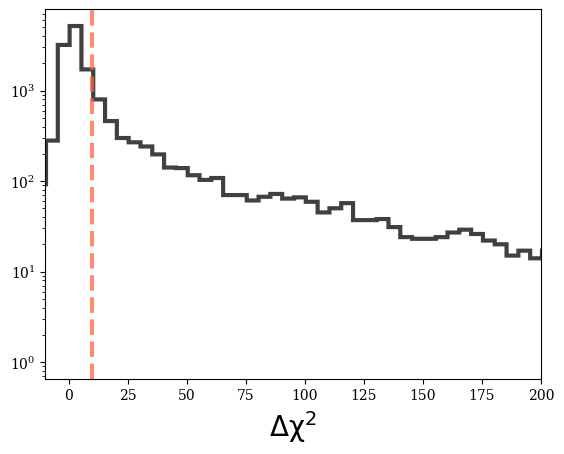

In [107]:
del_rchisq = flstbl['cmp_rchisq'] - flstbl['kn_rchisq']
flstbl['del_rchisq'] = del_rchisq

bins = np.arange(del_rchisq.min(), del_rchisq.max()+5, 5)
_ = plt.hist(del_rchisq, color='k', bins=bins, histtype='step', lw=3, alpha=0.75)
plt.axvline(x=10, ls='--', color='tomato', lw=3, alpha=0.75)
_ = plt.yscale('log')
_ = plt.xlabel(r'$\rm \Delta \chi^{2}$')
plt.xlim([-10, 200])

ratio = len(del_rchisq[del_rchisq>=10])/len(del_rchisq)
print(f"{ratio:1.3f}")

t=0.125 8.809
t=0.250 4.564
t=0.500 3.622
t=1.000 2.495
t=1.542 2.427
t=2.000 1.955


/Users/paek/opt/miniconda3/envs/kn/lib/python3.10/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Text(0, 0.5, '$\\rm \\chi^{2}_{other}-\\chi^{2}_{KN}$')

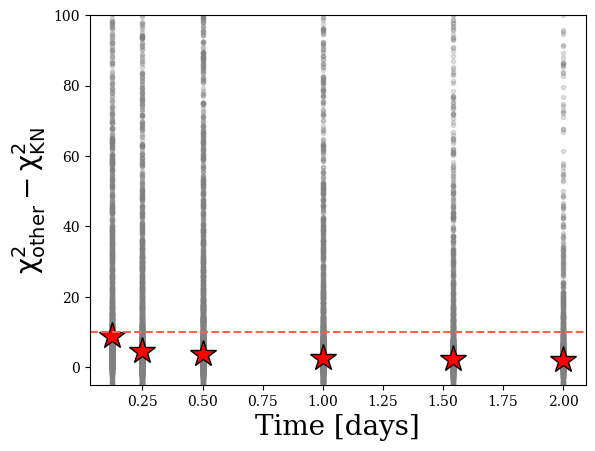

In [108]:
times = np.unique(flstbl['t'])
for t in times:
	tflstbl = flstbl[flstbl['t']==t]
	med = np.median(tflstbl['del_rchisq'])
	plt.plot([t]*len(tflstbl), tflstbl['del_rchisq'], color='grey', ls='none', marker='.', alpha=0.25)
	# plt.boxplot(tflstbl['del_rchisq'])
	plt.plot(t, med, marker='*', color='red', ms=20, mec='k')
	print(f"t={t:1.3f} {med:1.3f}")

plt.axhline(y=10, ls='--', color='tomato')
plt.ylim([-5, 100])
plt.xlabel('Time [days]')
plt.ylabel(r'$\rm \chi^{2}_{other}-\chi^{2}_{KN}$')

t=0.000 3.520
t=30.000 3.657
t=60.000 3.588
t=90.000 4.077
t=120.000 3.888
t=150.000 3.326
t=180.000 3.216


Text(0, 0.5, '$\\rm \\chi^{2}_{other}-\\chi^{2}_{KN}$')

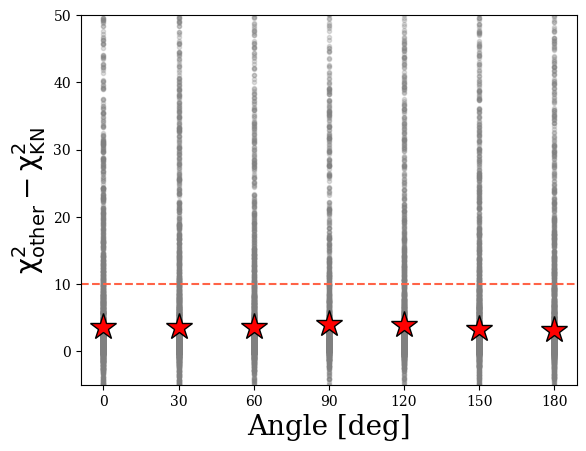

In [109]:
angles = np.unique(flstbl['angle'])
for ang in angles:
	tflstbl = flstbl[flstbl['angle']==ang]
	med = np.median(tflstbl['del_rchisq'])
	plt.plot([ang]*len(tflstbl), tflstbl['del_rchisq'], color='grey', ls='none', marker='.', alpha=0.25)
	# plt.boxplot(tflstbl['del_rchisq'])
	plt.plot(ang, med, marker='*', color='red', ms=20, mec='k')
	print(f"t={ang:1.3f} {med:1.3f}")

plt.axhline(y=10, ls='--', color='tomato')
plt.ylim([-5, 50])
plt.xticks(np.arange(0, 180+30, 30))
plt.xlabel('Angle [deg]')
plt.ylabel(r'$\rm \chi^{2}_{other}-\chi^{2}_{KN}$')

# Which transients are the most confused?

- identification or not, whatever

In [110]:
def put_comparison_model_info(intbl, key='model'):

	intbl['cmp_model_name'] = ' '*100
	intbl['ver'] = ' '*100
	intbl['typ'] = ' '*100
	intbl['z'] = 0.0

	# cmpmdl = cmptbl['model'][0]
	for ii, cmpmdl in enumerate(intbl[key]):
		part = cmpmdl.split('_')

		mdl = part[0]
		ver = part[1].replace('v', '')
		typ = part[3]
		try:
			z = float(part[5].replace('z', ''))
		except:
			# print(ii, cmpmdl)
			z = 0.0

		intbl['cmp_model_name'][ii] = mdl
		intbl['ver'][ii] = ver
		intbl['typ'][ii] = typ
		intbl['z'][ii] = z

	return intbl

In [111]:
cmptbl = Table()
cmpmodels = np.unique(flstbl['cmp_bestfit'])
# cmptimes = np.unique(flstbl['cmp_t'])
cmptbl['model'] = cmpmodels
cmptbl['n'] = 0

# for kk, (cmpmdl, t) in enumerate(zip(cmpmodels, cmptimes)):
for kk, cmpmdl in enumerate(cmptbl['model']):
	n_mdl = len(flstbl[
		(flstbl['cmp_bestfit']==cmpmdl)
	])
	# print(kk, cmpmdl, n_mdl)
	cmptbl['n'][kk] = n_mdl

cmptbl = cmptbl[np.argsort(-1*cmptbl['n'])]
cmptbl = put_comparison_model_info(cmptbl)

ntop = 10
print(f'# Top {ntop}')
for mm, mdl in enumerate(cmptbl['cmp_model_name'][:ntop]):
	n = cmptbl['n'][mm]
	typ = cmptbl['typ'][mm]
	print(mm+1, mdl, f"Type {typ} SN ({n})")

# Top 10
1 v19-2009ip-corr Type IIn SN (1286)
2 v19-2004et-corr Type IIP SN (931)
3 v19-1999em-corr Type IIP SN (861)
4 v19-1999em-corr Type IIP SN (848)
5 hsiao Type Ia SN (773)
6 hsiao Type Ia SN (742)
7 v19-2009ip-corr Type IIn SN (667)
8 v19-1993j-corr Type IIb SN (644)
9 v19-2007pk-corr Type IIn SN (554)
10 v19-2007pk-corr Type IIn SN (519)


- Number for each type

In [112]:
#	Consider SN rate
snrtbl = ascii.read('../3.table/snrate_Li+12.tsv')

wnlist = []
for typ in np.unique(cmptbl['typ']):
	n = np.sum(cmptbl['n'][cmptbl['typ']==typ])
	if typ in snrtbl['type']:
		wn = n*snrtbl['ratio'][snrtbl['type']==typ].item()
		print(f"{typ}\t{n}\t--> {wn:1.1f}")
		wnlist.append(wn)

IIL	1190	--> 67.8
IIP	3986	--> 1590.4
IIb	1571	--> 107.5
IIn	4308	--> 221.0
Ia	2211	--> 530.6
Ib	981	--> 39.1
Ic	1615	--> 165.7


- Top 10
1 v19-2009ip-corr Type IIn SN (1287)
2 v19-1999em-corr Type IIP SN (1070)
3 v19-2009ip-corr Type IIn SN (1067)
4 v19-2007pk-corr Type IIn SN (1056)
5 v19-2009ip-corr Type IIn SN (734)
6 v19-1993j-corr Type IIb SN (555)
7 v19-2004gt-corr Type Ic SN (550)
8 v19-2007pk-corr Type IIn SN (548)
9 v19-2004et-corr Type IIP SN (539)
10 nugent-sn2l Type IIL SN (535)

IIL 1190
IIP 3986
IIb 1571
IIn 4308
Ia 2211
Ib 981
Ic 1615
asteroid 50


/var/folders/73/438czwkx0jb_7z61gc79vcb40000gn/T/ipykernel_27019/3430284508.py:21: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')


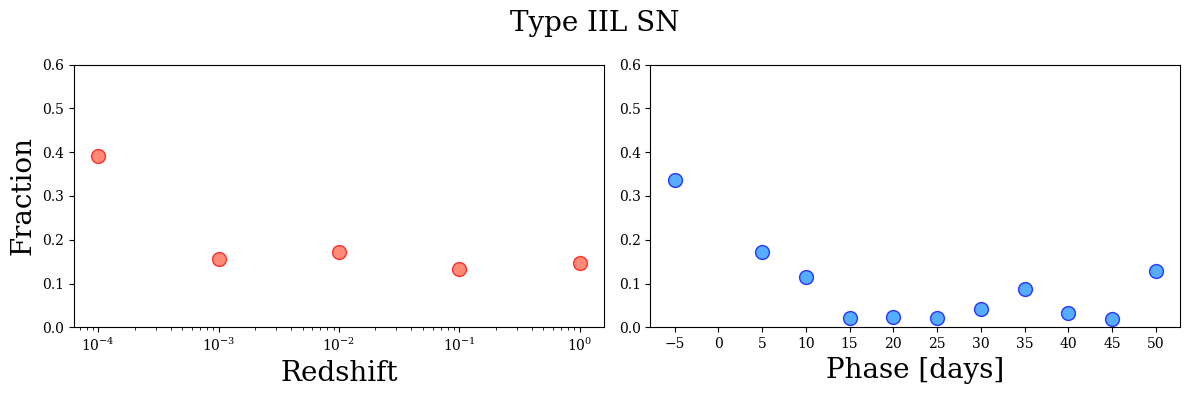

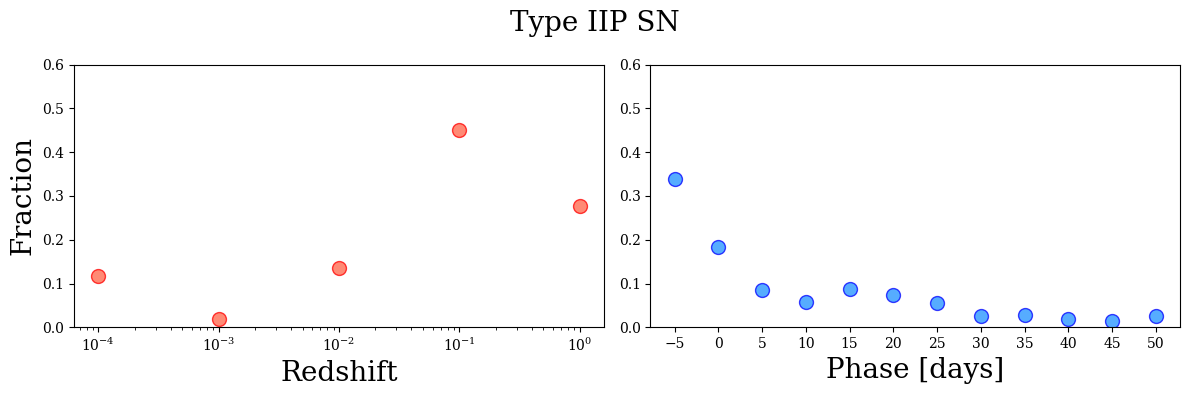

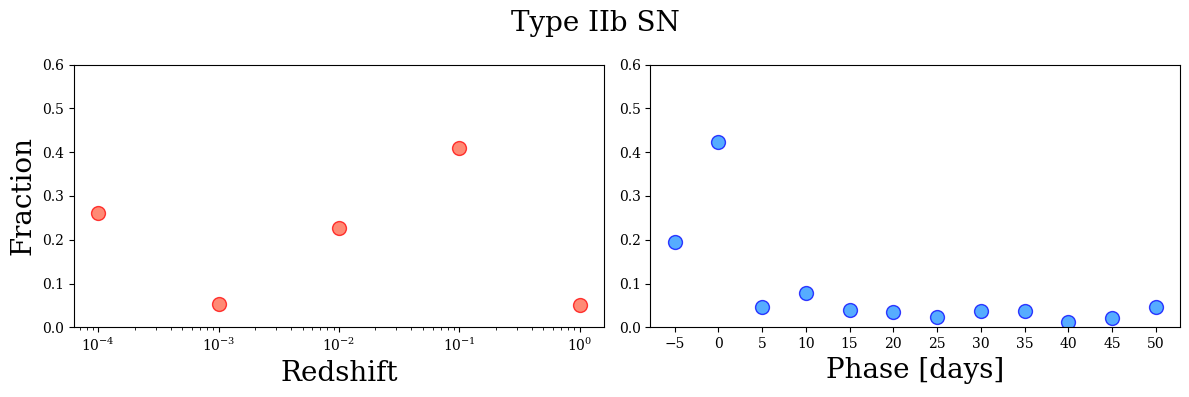

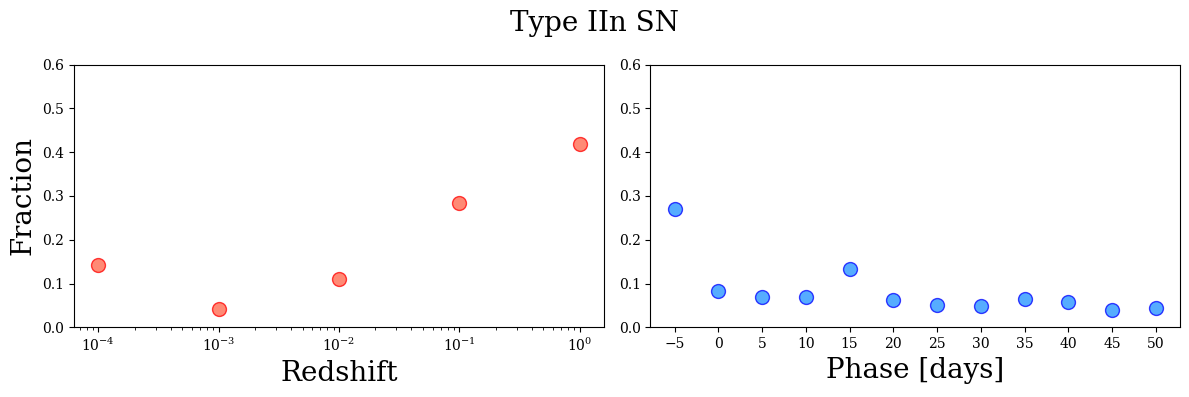

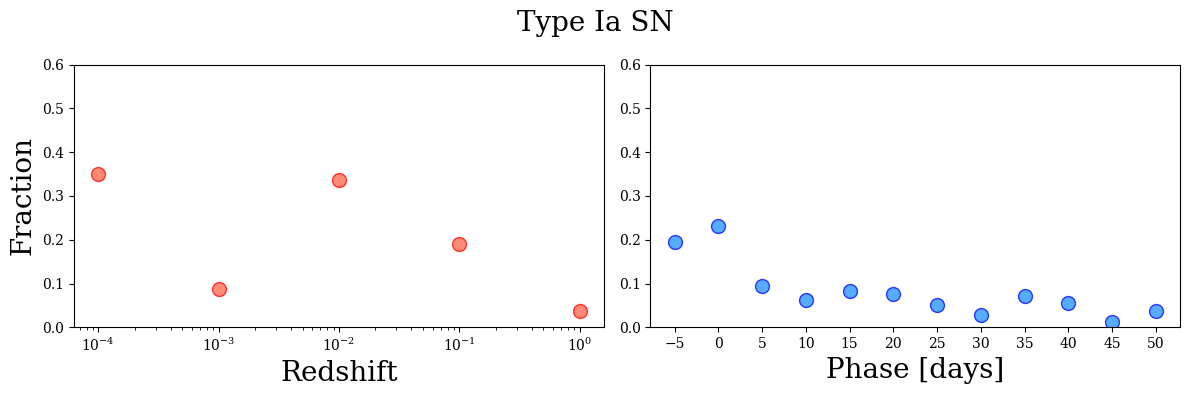

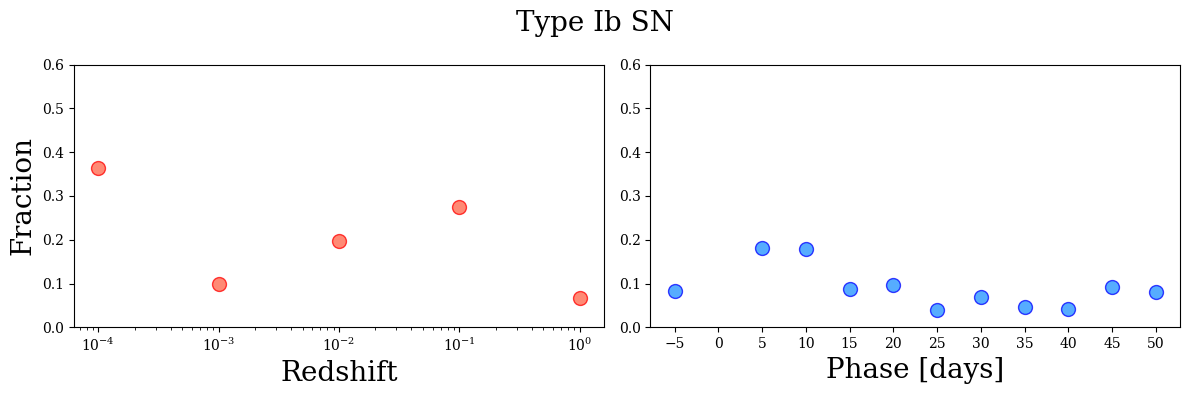

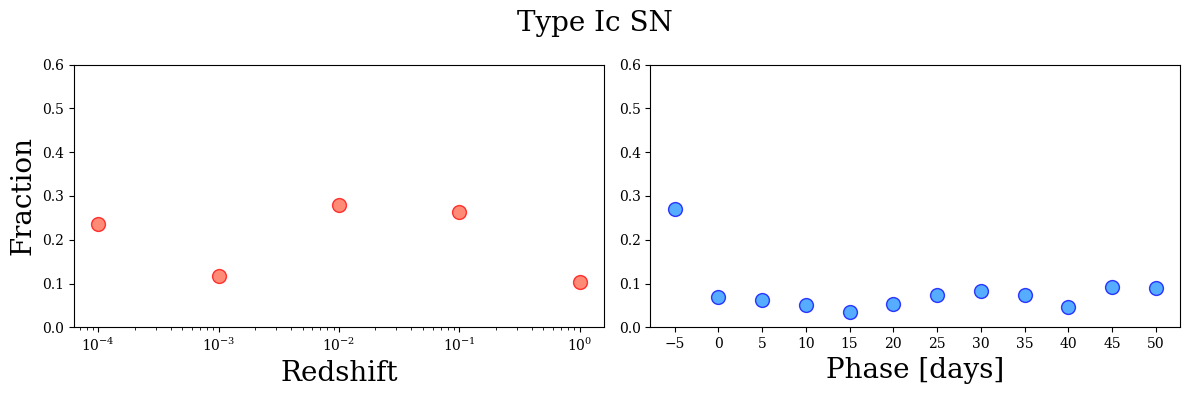

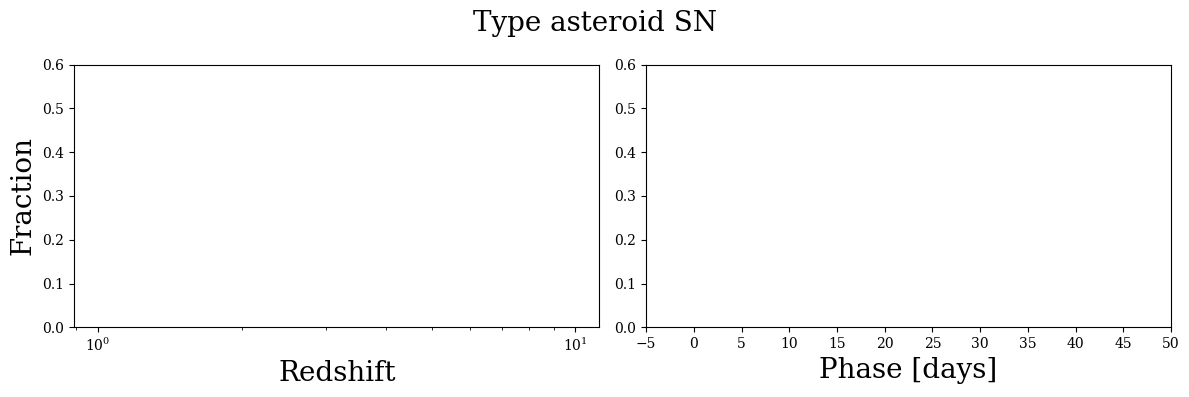

In [113]:
yu = 0.6
mflstbl = put_comparison_model_info(flstbl, key='cmp_bestfit')

for typ in np.unique(cmptbl['typ']):
	n = np.sum(cmptbl['n'][cmptbl['typ']==typ])
	print(typ, n)


	# typ = 'IIP'
	tmptbl = mflstbl[mflstbl['typ']==typ]

	zarr = np.unique(tmptbl['z'])
	tarr = np.unique(tmptbl['cmp_t'])

	fig = plt.figure(figsize=(12, 4))
	plt.suptitle(f"Type {typ} SN", fontsize=20)
	plt.subplot(1, 2, 1)
	# plt.title('Redshift')
	plt.plot(zarr, [len(tmptbl[tmptbl['z']==z])/len(tmptbl) for z in zarr], marker='o', ms=10, ls='none', color='tomato', mec='red', alpha=0.75)
	plt.xlabel('Redshift')
	plt.xscale('log')
	plt.ylabel('Fraction')
	plt.ylim([0, yu])

	plt.subplot(1, 2, 2)
	plt.plot(tarr, [len(tmptbl[tmptbl['cmp_t']==t])/len(tmptbl) for t in tarr], marker='o', ms=10, ls='none', color='dodgerblue', mec='blue', alpha=0.75)
	plt.xlabel('Phase [days]')
	plt.ylim([0, yu])
	plt.xticks(np.arange(-5, 50+5, 5))

	plt.tight_layout()
	# plt.xscale('log')
	plt.savefig(f'../5.result/fit_kn2all/{tag}/type_{typ}_sn_dependence.png',)



/var/folders/73/438czwkx0jb_7z61gc79vcb40000gn/T/ipykernel_27019/425660403.py:3: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')


(0.0, 0.6)

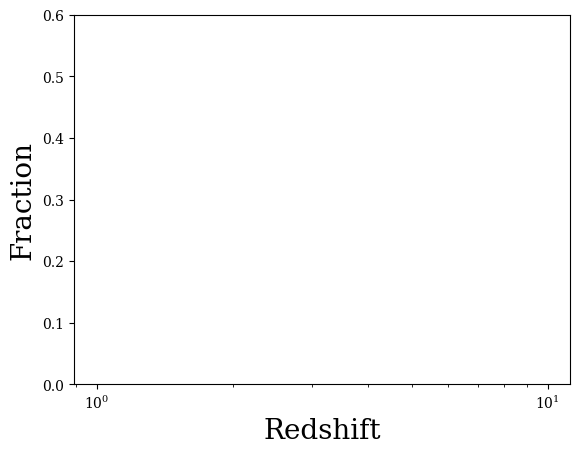

In [114]:
plt.plot(zarr, [len(mflstbl[mflstbl['z']==z])/len(mflstbl) for z in zarr], marker='o', ms=10, ls='none', color='tomato', mec='red', alpha=0.75)
plt.xlabel('Redshift')
plt.xscale('log')
plt.ylabel('Fraction')
plt.ylim([0, yu])

# Confusion matrix for the KN identification

In [115]:
#	Crietrion
crit = 5
indx_ident = np.where(flstbl['del_rchisq']>=crit)
ilstbl = flstbl[indx_ident]

In [116]:
key0 = 'md'
key1 = 'mw'

# arr0 = flstbl[key0]
# arr1 = flstbl[key1]
arr0 = ilstbl[key0]
arr1 = ilstbl[key1]

# alarr0 = ilstbl[key0]
# alarr1 = ilstbl[key1]
alarr0 = flstbl[key0]
alarr1 = flstbl[key1]

(conf_matrix, conf_matrix_all) = make_confusion_matrix(arr0, arr1, alarr0, alarr1)
print(conf_matrix)
print(conf_matrix_all)

[[590 594 569 593 584]
 [435 450 423 440 465]
 [240 246 244 275 272]
 [ 87  92  96 105 127]
 [  6  10  17  29  55]]
[[ 926  948  957  955 1017]
 [ 887  884  890  931  997]
 [ 629  647  684  715  844]
 [ 315  338  385  450  601]
 [  69   91  144  204  404]]


In [117]:
labeldict = dict(
	#	Dyn.
	vd = r"Dynamical Ejecta Velocity [c]",
	md = r"Dynamical Ejecta Mass [$\rm M_{\odot}$]",
	#	Wind
	vw = r"Wind Ejecta Velocity [c]",
	mw = r"Wind Ejecta Mass [$\rm M_{\odot}$]",
)

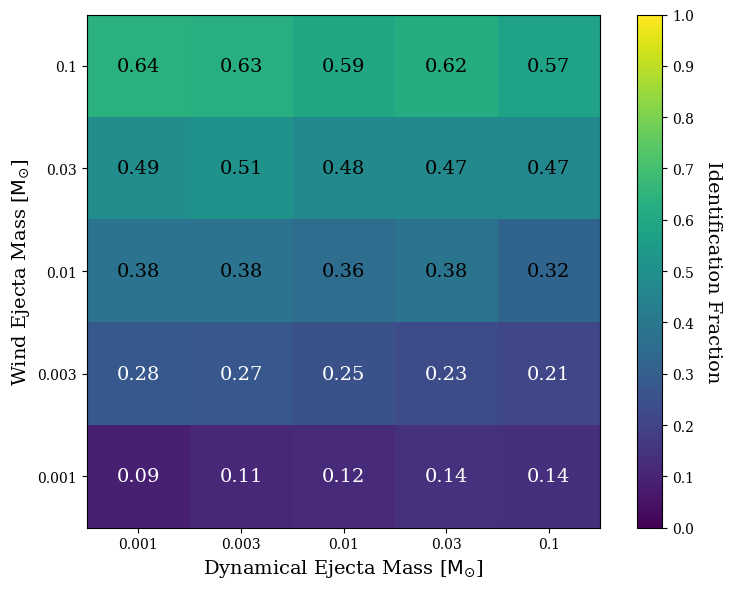

In [118]:
cmap = plt.cm.viridis
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(conf_matrix/conf_matrix_all, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=1.0)  # , cmap=plt.cm.Greens
cbar = fig.colorbar(cax, ticks=np.arange(0, 1.0+0.1, 0.1))
# cbar.set_label('Fraction Consistent with Upper Limits', rotation=270, fontsize=14, labelpad=20)
cbar.set_label('Identification Fraction', rotation=270, fontsize=14, labelpad=20)

_ = ax.set_xticks(np.arange(len(np.unique(arr0))), np.unique(arr0))
_ = ax.set_yticks(np.arange(len(np.unique(arr1))), np.flipud(np.unique(arr1)))
_ = ax.set_xlabel(labeldict[key0], fontsize=14)
_ = ax.set_ylabel(labeldict[key1], fontsize=14)

fmt = '1.2f'
thresh = 0.3
fs = 14 # fontsize
for i in range(conf_matrix.shape[0]):
	for j in range(conf_matrix.shape[1]):
		ax.text(j, i, format(conf_matrix[i, j]/conf_matrix_all[i, j], fmt), fontsize=fs, ha="center", va="center", color="white" if conf_matrix[i, j]/conf_matrix_all[i, j] < thresh else "black")  #horizontalalignment

plt.tight_layout()
# plt.savefig(f"{path_plot}/kn.ejecta_mass.constraint.png")
# plt.savefig(f"{path_plot}/kn.ejecta_mass.constraint.pdf")

0.16113636363636363 0.7027272727272726


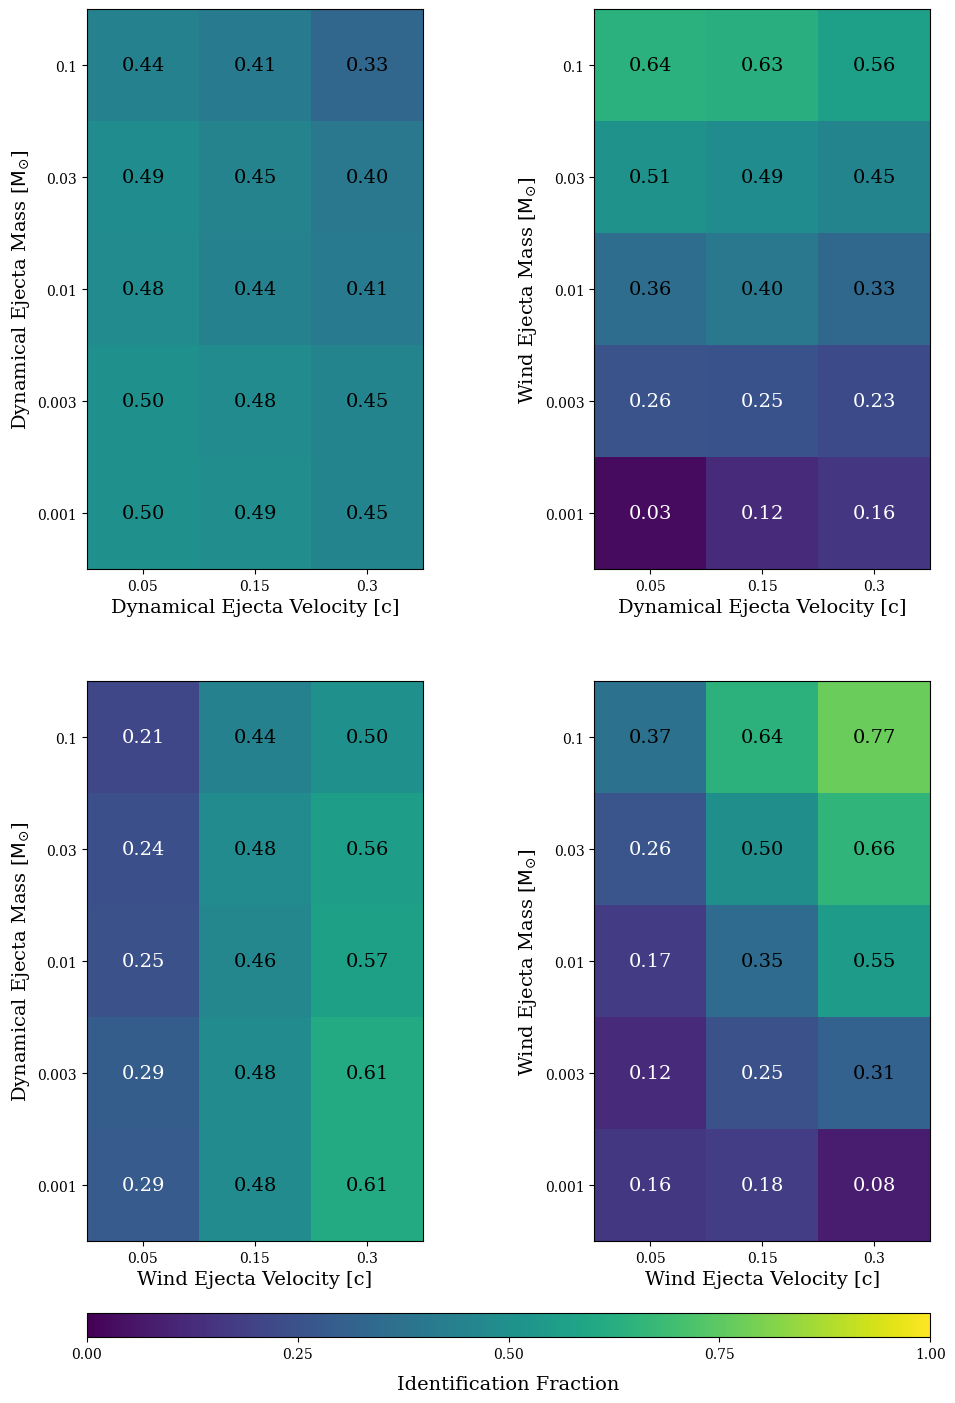

In [119]:
#	Plot
plt.close('all')
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axs = plt.subplots(2, 2, figsize=(12, 16))
ax0, ax1, ax2, ax3 = axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]

#	Keys
keys0 = ['vd', 'vd', 'vw', 'vw']
keys1 = ['md', 'mw', 'md', 'mw']

for key0, key1, ax, in zip(keys0, keys1, [ax0, ax1, ax2, ax3],):

	arr0 = ilstbl[key0]
	arr1 = ilstbl[key1]
	alarr0 = flstbl[key0]
	alarr1 = flstbl[key1]
	(conf_matrix, conf_matrix_all) = make_confusion_matrix(arr0, arr1, alarr0, alarr1)

	cmap = plt.cm.viridis
	im = ax.imshow(conf_matrix/conf_matrix_all, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=1.0)  # , cmap=plt.cm.Greens

	_ = ax.set_xticks(np.arange(len(np.unique(arr0))), np.unique(arr0))
	_ = ax.set_yticks(np.arange(len(np.unique(arr1))), np.flipud(np.unique(arr1)))
	_ = ax.set_xlabel(labeldict[key0], fontsize=14)
	_ = ax.set_ylabel(labeldict[key1], fontsize=14)

	fmt = '1.2f'
	thresh = 0.3
	fs = 14 # fontsize
	for i in range(conf_matrix.shape[0]):
		for j in range(conf_matrix.shape[1]):
			ax.text(j, i, format(conf_matrix[i, j]/conf_matrix_all[i, j], fmt), fontsize=fs, ha="center", va="center", color="white" if conf_matrix[i, j]/conf_matrix_all[i, j] < thresh else "black")  #horizontalalignment

p0 = ax0.get_position().get_points().flatten()
p1 = ax1.get_position().get_points().flatten()
p2 = ax2.get_position().get_points().flatten()
p3 = ax3.get_position().get_points().flatten()

ax_cbar = fig.add_axes([p0[0], 0.05, (p1[2]-p0[0]), 0.015], aspect='auto')
print(p0[0], p1[2]-p0[0])
cbar = fig.colorbar(im, cax=ax_cbar, orientation='horizontal', ticks=np.arange(0, 1.0+0.25, 0.25))
cbar.set_label('Identification Fraction', rotation=0, fontsize=14, labelpad=10)

# plt.savefig(f"{path_plot}/kn.all.constraint.png")
# plt.savefig(f"{path_plot}/kn.all.constraint.pdf")

([<matplotlib.patches.Wedge at 0x15fe6b4c0>,
 [Text(0.04967291304173465, 1.0988778829833405, 'Ib'),
  Text(0.1846105704387909, 1.0843979607516165, 'IIL'),
  Text(0.39871915211341713, 1.0251941463634866, 'IIb'),
  Text(0.6969278018640532, 0.8510532527338928, 'Ic'),
  Text(0.9959949335262879, 0.46689837479901947, 'IIn'),
  Text(1.0002795919964231, -0.45764695763816593, 'Ia'),
  Text(-1.061701006591768, -0.2877342047828638, 'IIP')],
 [Text(0.02709431620458253, 0.5993879361727311, '1.4%'),
  Text(0.10069667478479503, 0.5914897967736089, '2.5%'),
  Text(0.21748317388004568, 0.5591968071073563, '3.9%'),
  Text(0.3801424373803926, 0.4642108651275778, '6.1%'),
  Text(0.5432699637416115, 0.25467184079946514, '8.1%'),
  Text(0.5456070501798671, -0.24962561325718138, '19.5%'),
  Text(-0.5791096399591461, -0.15694592988156209, '58.4%')])

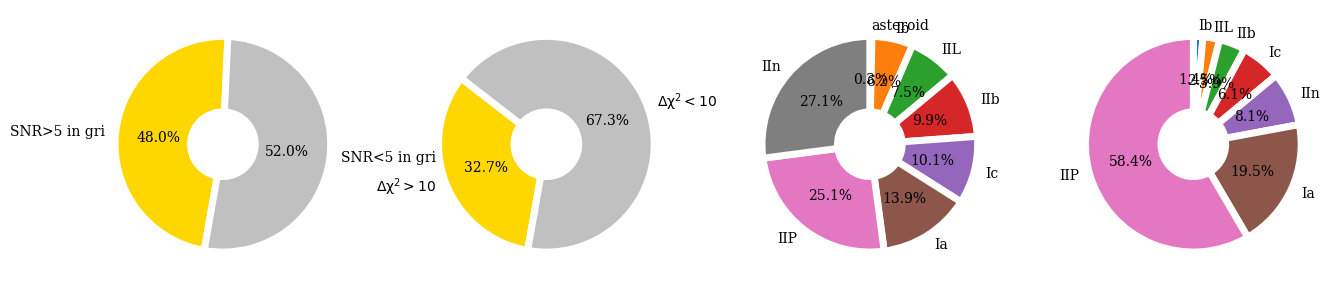

In [120]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 4))



plt.subplot(1, 4, 1)
ratio = [
	len(lstbl[indx_nskip]),
	len(lstbl[indx_skip]),
]
labels = ['SNR>5 in gri', 'SNR<5 in gri', 'Melon', 'Grapes'][:2]
colors = ['#ff9999', '#ffc000', '#8fd9b6', '#d395d0'][:2]
colors = ['gold', 'silver',]
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, colors=colors, wedgeprops=wedgeprops)

plt.subplot(1, 4, 2)
ratio = [
	len(del_rchisq[del_rchisq>=10]),
	len(del_rchisq[del_rchisq<10]),
]
labels = [r'$\rm \Delta \chi^{2}>10$', r'$\rm \Delta \chi^{2}<10$', 'Melon', 'Grapes'][:2]
# colors = ['#ff9999', '#ffc000', '#8fd9b6', '#d395d0'][2:]
colors = ['gold', 'silver']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, colors=colors, wedgeprops=wedgeprops)

plt.subplot(1, 4, 3)
ratio = []
labels = []
for typ in np.unique(cmptbl['typ']):
	n = np.sum(cmptbl['n'][cmptbl['typ']==typ])
	# print(typ, n)
	ratio.append(n)
	labels.append(typ)

ratio = np.array(ratio)
labels = np.array(labels)[np.argsort(ratio)]
ratio = ratio[np.argsort(ratio)]

# labels = [r'$\rm \Delta \chi^{2}>10$', r'$\rm \Delta \chi^{2}<10$', 'Melon', 'Grapes'][:2]
# colors = ['#ff9999', '#ffc000', '#8fd9b6', '#d395d0'][2:]
# colors = ['gold', 'yellow']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=90, counterclock=False, wedgeprops=wedgeprops)


plt.subplot(1, 4, 4)
ratio = []
labels = []
for typ, wn in zip(np.unique(cmptbl['typ']), wnlist):
	# n = np.sum(cmptbl['n'][cmptbl['typ']==typ])
	# print(typ, n)
	ratio.append(wn)
	labels.append(typ)

ratio = np.array(ratio)
labels = np.array(labels)[np.argsort(ratio)]
ratio = ratio[np.argsort(ratio)]

# labels = [r'$\rm \Delta \chi^{2}>10$', r'$\rm \Delta \chi^{2}<10$', 'Melon', 'Grapes'][:2]
# colors = ['#ff9999', '#ffc000', '#8fd9b6', '#d395d0'][2:]
# colors = ['gold', 'yellow']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=90, counterclock=False, wedgeprops=wedgeprops)


In [121]:
mflstbl.write(f'../5.result/fit_kn2all/{tag}/fit.only.detect.fits', format='fits', overwrite=True)